In [20]:
## Name: Chang Liu (cliu8)
## HW2 Exercise 3

# load in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import cdist
from scipy.linalg import inv


# Read a CSV file (assuming numeric values only)
data = pd.read_csv("./classification.csv", header = 0) 
# X is feature, y is label
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

SEED_LIST = range(5, 10)  # 5 different seeds for different runs

# Function to initialize training & testing sets
def initialize_data(seed, initial_prob):
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_idx = int(initial_prob * len(X))
    train_idx, pool_idx = indices[:split_idx], indices[split_idx:]
    return train_idx, pool_idx

# Function to train random forest & compute accuracy
def evaluate_model(train_X, train_y, model):
    scores = cross_val_score(model, train_X, train_y, cv=5, scoring='accuracy')
    return np.mean(scores)



class ZLG:
    def __init__(self, t=0.1):
        self.t = t  # Threshold for removing weak edges
        self.W = None  # Adjacency matrix
        self.L = None  # Graph Laplacian

    # function to construct the weighted adjacency matrix using radius basis function (similarity)
    def build_graph(self, X):
        sigma = np.var(X)
        W = np.exp(-cdist(X, X, metric='sqeuclidean') / (2 * sigma**2))  # RBF kernel
        W[W < self.t] = 0.0 # Apply thresholding
        self.W = W
        self.L = np.diag(W.sum(axis=1)) - W  # Compute graph Laplacian
    

    # function to propagate labels by harmonic functions
    def harmonic(self, pool_X, train_X, train_Y):
        n_train = train_X.shape[0]
        n_pool = pool_X.shape[0]
        
        L_UU = self.L[n_train:, n_train:]  # Unlabeled portion of Laplacian
        L_UL = self.L[n_train:, :n_train]  # Connections from pool to labeled set
        
        try:
            L_UU_inv = inv(L_UU)
        except np.linalg.LinAlgError:
            eps = 1e-9  # Small value to prevent singularity issues
            L_UU_inv = inv(L_UU + eps * np.eye(n_pool))
        
        f_U = -L_UU_inv @ L_UL @ train_Y  # Harmonic function solution
        return f_U, L_UU_inv

    

    # function to update harmonic functions
    def update_solution(self, f_u, L_uu_inv, k_sub, y_k):
        f_u_new = f_u.copy()
        delta = (y_k - f_u[k_sub]) / L_uu_inv[k_sub, k_sub]
        f_u_new += delta * L_uu_inv[:, k_sub]
        return f_u_new

    # function to approximate risk for current solution
    def approximate_risk(self, f):
        return np.sum(np.minimum(f, 1 - f))

    # function to calculate expected future risk for candidates
    def expected_future_risk(self, f, f_u, L_uu_inv, c, k_sub, unlabeled_indices):
        p1 = f[c]
        p0 = 1.0 - p1
        
        f_u_0 = self.update_solution(f_u, L_uu_inv, k_sub, 0.0)
        f_0 = f.copy()
        f_0[unlabeled_indices] = f_u_0
        risk0 = self.approximate_risk(f_0)
        
        f_u_1 = self.update_solution(f_u, L_uu_inv, k_sub, 1.0)
        f_1 = f.copy()
        f_1[unlabeled_indices] = f_u_1
        risk1 = self.approximate_risk(f_1)
        
        return p0 * risk0 + p1 * risk1
    
    
    
    # select the point with min future risk
    def select_instance(self, f, f_u, L_uu_inv, unlabeled_indices):
        risks = [self.expected_future_risk(f, f_u, L_uu_inv, c, k, unlabeled_indices) for k, c in enumerate(unlabeled_indices)]
        return unlabeled_indices[np.argmin(risks)]
    


def run_simulation(X, y, seeds=SEED_LIST):
    seed_scores = []
    # run 10 seeds
    for seed in seeds:
        train_idx, pool_idx = initialize_data(seed, 0.2) # 20% of data as initial training set
        train_X, train_y = X[train_idx], y[train_idx]
        pool_X, pool_y = X[pool_idx], y[pool_idx]
        # do model prediction
        forest = RandomForestClassifier(n_estimators=50, random_state=42)
        forest.fit(train_X, train_y)
        cv_scores = []
        
        for _ in range(len(pool_X)):

            score = evaluate_model(train_X, train_y, forest)
            cv_scores.append(score)
            
            query = ZLG()
            query.build_graph(X)
            f_u, L_uu_inv = query.harmonic(pool_X, train_X, train_y)
            query_idx = query.select_instance(f_u, f_u, L_uu_inv, np.arange(len(pool_X)))
                    
            train_X = np.vstack([train_X, pool_X[query_idx]])
            train_y = np.append(train_y, pool_y[query_idx])
            pool_X = np.delete(pool_X, query_idx, axis=0)
            pool_y = np.delete(pool_y, query_idx, axis=0)
            
            forest.fit(train_X, train_y)  # Retrain the random forest with the new data point
        seed_scores.append(cv_scores)
        print(f"This is seed {seed}.")
    seed_scores = np.array(seed_scores)
    mean = np.mean(seed_scores, axis=0)
    std = np.std(seed_scores, axis=0)
    
    return mean, std



In [23]:
# run the simulation
train_mean_5, train_std_5 = run_simulation(X, y)

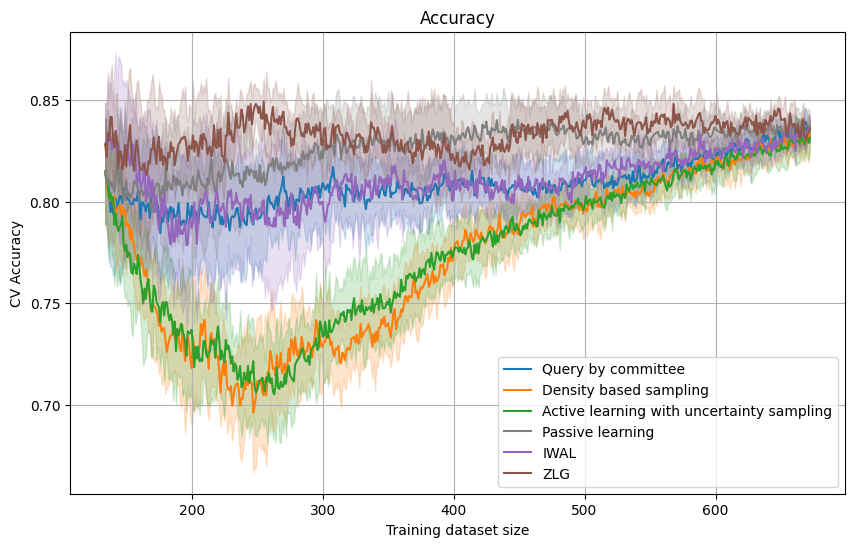

In [17]:
# Load the data
exe1 = pd.read_csv('./exe1_data.csv', header=0)
exe2 = pd.read_csv('./exe2_data.csv',  header=0)
# Define the x-axis range
x_values = range(int(0.2 * len(X)), int(0.2 * len(X)) + len(exe1['train_mean']))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for Query by committee
plt.plot(x_values, exe1['train_mean'], label='Query by committee', color='#1f77b4')
plt.fill_between(x_values, exe1['train_mean'] - exe1['train_std'], exe1['train_mean'] + exe1['train_std'], color='#1f77b4', alpha=0.2)

# Plot for Density based sampling
plt.plot(x_values, exe1['train_mean_1'], label='Density based sampling', color='#ff7f0e')
plt.fill_between(x_values, exe1['train_mean_1'] - exe1['train_std_1'], exe1['train_mean_1'] + exe1['train_std_1'], color='#ff7f0e', alpha=0.2)

# Plot for Active learning with uncertainty sampling
plt.plot(x_values, exe1['train_mean_2'], label='Active learning with uncertainty sampling', color='#2ca02c')
plt.fill_between(x_values, exe1['train_mean_2'] - exe1['train_std_2'], exe1['train_mean_2'] + exe1['train_std_2'], color='#2ca02c', alpha=0.2)

# Plot for Passive learning
plt.plot(x_values, exe1['train_mean_3'], label='Passive learning', color='#7f7f7f')
plt.fill_between(x_values, exe1['train_mean_3'] - exe1['train_std_3'], exe1['train_mean_3'] + exe1['train_std_3'], color='#7f7f7f', alpha=0.2)

# Plot for IWAL 
plt.plot(x_values, exe2['train_mean_4'], label='IWAL', color='#9467bd')
plt.fill_between(x_values, exe2['train_mean_4'] - exe2['train_std_4'], exe2['train_mean_4'] + exe2['train_std_4'], color='#9467bd', alpha=0.2)

# Plot for ZLG 
plt.plot(x_values, train_mean_5, label='ZLG', color='#8c564b')
plt.fill_between(x_values, train_mean_5 - train_std_5, train_mean_5 + train_std_5, color='#8c564b', alpha=0.2)


# Add labels, title, and legend
plt.xlabel('Training dataset size')
plt.ylabel('CV Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()